In [49]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample

In [50]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import nltk
import seaborn as sns
import re
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [51]:
##train_data = pd.read_csv("../input/emotions-dataset-for-nlp/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

df = pd.read_csv('Emotion_final.csv')

In [52]:
EMBEDDING_FILE= f'glove.6B.100d.txt'  #GloVe file path
EMBEDDING_FILE

'glove.6B.100d.txt'

In [53]:
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


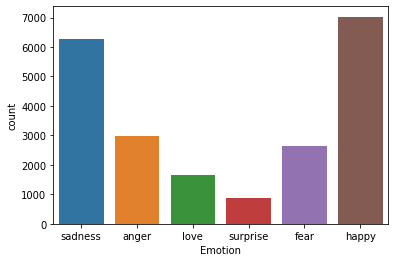

In [54]:
sns.countplot(df.Emotion)
plt.show()

In [55]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [56]:
df=df.dropna() #Drop columns with NA values
X=df.drop('Emotion',axis=1) #Input
y=df['Emotion'] #Output

In [57]:
messages=X.copy()
messages.reset_index(inplace=True) #Drop NA may cause inconsistency in index

In [58]:
nltk.download('stopwords')
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['Text'][i]) #Remove Special Characters
    review = review.lower() #Lower case 
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')] #Remove stopwords
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/harukageorge/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
corpus[:10]

['didnt feel humili',
 'go feel hopeless damn hope around someon care awak',
 'im grab minut post feel greedi wrong',
 'ever feel nostalg fireplac know still properti',
 'feel grouchi',
 'ive feel littl burden late wasnt sure',
 'ive take milligram time recommend amount ive fallen asleep lot faster also feel like funni',
 'feel confus life teenag jade year old man',
 'petrona year feel petrona perform well made huge profit',
 'feel romant']

In [60]:
#Creating the dictionary with word as key and pretrained-value array as value
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf-8'))

#Calculate mean and std for the pretrained weights
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
print(emb_mean,emb_std)

/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


0.004451992 0.4081574


In [61]:
voc_size=10000 # Vocabulary size
embed_size=100 #word vector size

tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(list(corpus))
word_index = tokenizer.word_index #Total words in the corpus
nb_words = min(voc_size, len(word_index))

#Initialize weight matrix for embedding layer
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size)) 

for word, i in word_index.items():
    if i >= voc_size: continue #Skip the words if vocab size is reached
    embedding_vector = embeddings_index.get(word) #Extract the pretrained values from GloVe
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [62]:
#Contains the pretrained GloVe weights for the words
len(embedding_matrix)

10000

In [63]:
#One hot representation for input
onehot_repr=[one_hot(words,voc_size)for words in corpus]

#Finding max words
l = 0
for x in corpus:
    l = max(l,len(x.split(' ')))

#Padding the sequences for input
sent_length= l
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)

In [64]:
print(embedded_docs)

[[   0    0    0 ... 9690 6714 2738]
 [   0    0    0 ... 2667 6534 2394]
 [   0    0    0 ... 6714 7554 1648]
 ...
 [   0    0    0 ... 8951 9887 5446]
 [   0    0    0 ... 7894 5446 8622]
 [   0    0    0 ...    0 5446 9738]]


In [65]:
#Encoding the target outputs to integers
label_encoder = preprocessing.LabelEncoder()

X_final=np.array(embedded_docs) #input to array
y = label_encoder.fit_transform(y)
y_final=np.array(y)
print(y_final)

[4 4 0 ... 1 1 1]


In [66]:
X_final.shape,y_final.shape

((21459, 35), (21459,))

In [67]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, 
                                                    test_size=0.2, random_state=42) 
#Train-Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.1, random_state=21) 

In [68]:
y_test.shape, y_val.shape

((4292,), (1717,))

In [69]:
X_train.shape, y_train.shape

((15450, 35), (15450,))

In [70]:
from imblearn.over_sampling import SMOTE

In [71]:
#pip install imblearn

In [72]:
y

array([4, 4, 0, ..., 1, 1, 1])

In [73]:
y_final

array([4, 4, 0, ..., 1, 1, 1])

In [74]:
X_final

array([[   0,    0,    0, ..., 9690, 6714, 2738],
       [   0,    0,    0, ..., 2667, 6534, 2394],
       [   0,    0,    0, ..., 6714, 7554, 1648],
       ...,
       [   0,    0,    0, ..., 8951, 9887, 5446],
       [   0,    0,    0, ..., 7894, 5446, 8622],
       [   0,    0,    0, ...,    0, 5446, 9738]], dtype=int32)

#### SMOTE

In [75]:
sm = SMOTE(random_state = 42, sampling_strategy='minority')

x_new, y_new = sm.fit_resample(X_final, y_final)


In [76]:
x_new.shape, X_final.shape, y_new.shape, y_final.shape

((27609, 35), (21459, 35), (27609,), (21459,))

In [77]:
x_new = pd.DataFrame(x_new)
X_final = pd.DataFrame(X_final)
y_new = pd.DataFrame(y_new)
y_final = pd.DataFrame(y_final)

In [78]:
y_new.value_counts()

2    7029
5    7029
4    6265
0    2993
1    2652
3    1641
dtype: int64

In [79]:
y_final.value_counts()

2    7029
4    6265
0    2993
1    2652
3    1641
5     879
dtype: int64

In [80]:
y_new = y_new.to_numpy()

In [81]:
y_new

array([[4],
       [4],
       [0],
       ...,
       [5],
       [5],
       [5]])

In [82]:
x_new

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9690,6714,2738
1,0,0,0,0,0,0,0,0,0,0,...,0,7416,6714,7544,2240,2,3013,2667,6534,2394
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6560,1666,1040,4582,6714,7554,1648
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1268,6714,1845,2431,3157,8174,3839
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6714,9839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27604,0,0,0,0,0,0,0,0,0,0,...,5526,6192,1443,3826,4303,1380,3888,1039,4374,8881
27605,0,0,0,0,0,0,0,0,0,0,...,0,0,0,6714,6952,727,3393,5671,5503,4864
27606,0,0,0,0,0,0,0,0,0,0,...,9698,987,7542,6701,6883,6518,4101,1830,8918,1492
27607,0,0,0,0,0,0,0,0,0,0,...,3405,4109,1356,5075,4518,6503,3289,6745,450,5163


In [83]:
x_new = x_new.to_numpy()

In [84]:
y_final

,0
0,4
1,4
2,0
3,3
4,0
...,...
21454,1
21455,1
21456,1
21457,1


In [195]:
#Down sampling

In [313]:
X_final = pd.DataFrame(X_final)

In [314]:
X_final['output'] = y_final

In [315]:
a_0 = X_final[X_final["output"] == 0]
a_1 = X_final[X_final["output"] == 1]
a_2 = X_final[X_final["output"] == 2]
a_3 = X_final[X_final["output"] == 3]
a_4 = X_final[X_final["output"] == 4]
a_5 = X_final[X_final["output"] == 5]


In [316]:
downsample_0 = resample(a_0,
             replace=False,
             n_samples=len(a_5),
             random_state=42)
downsample_1 = resample(a_1,
             replace=False,
             n_samples=len(a_5),
             random_state=42)
downsample_2 = resample(a_2,
             replace=False,
             n_samples=len(a_5),
             random_state=42)
downsample_3 = resample(a_3,
             replace=False,
             n_samples=len(a_5),
             random_state=42)
downsample_4 = resample(a_4,
             replace=False,
             n_samples=len(a_5),
             random_state=42)

In [317]:
data_downsampled = pd.concat([downsample_0, downsample_1, downsample_2, downsample_3, downsample_4, a_5])

print(data_downsampled["output"].value_counts())

0    879
1    879
2    879
3    879
4    879
5    879
Name: output, dtype: int64


In [318]:
data_downsampled.sort_index(inplace=True)

In [319]:
x_new = data_downsampled.drop(columns = 'output')
y_new = data_downsampled['output']

In [320]:
x_new

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,9893,5049,3301,5211,2767,3590,8397
6,0,0,0,0,0,0,0,0,0,0,...,2225,433,9939,4341,6157,3526,6700,2767,7732,1154
25,0,0,0,0,0,0,0,0,0,0,...,8668,3121,2190,4946,5999,5736,8347,936,2767,8156
32,0,0,0,0,0,0,0,0,0,0,...,2184,215,4838,5838,9658,2858,8397,2767,9304,1632
38,0,0,0,0,0,0,0,0,0,0,...,4854,6463,2754,9677,2767,7362,3590,9269,258,7931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21443,0,0,0,0,0,0,0,0,0,0,...,0,4391,2270,2507,2042,1315,2408,4838,2030,2245
21445,0,0,0,0,0,0,0,0,0,0,...,125,8159,8373,3320,1985,4779,3669,1691,5857,2391
21448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,7221,8778,9512,3669,2842,5815
21450,0,0,0,0,0,0,0,0,0,0,...,0,1068,7879,2334,1719,6431,7782,3669,729,855


In [321]:
y_new

2        0
6        5
25       4
32       5
38       0
        ..
21443    1
21445    1
21448    1
21450    1
21458    1
Name: output, Length: 5274, dtype: int64

### Model Building


In [85]:
activation = ['sigmoid', 'tanh']
optimizer = ['RMSprop','Adam', 'Adamax', 'Adadelta']
batch_size = [80, 100]
epochs = [50, 100]
param_grid = dict(activation=activation, batch_size=batch_size, epochs=epochs)

In [86]:
def create_model(activation = 'sigmoid', optimizer = 'Adam'):

    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(128, input_dim=x_new.shape[1],
                    activation=activation,
                    kernel_initializer='normal'))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation=activation))
    model.add(Dense(6, activation='softmax',
                    kernel_initializer='normal'))
    
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  # here we add a regulizer normalization function from Talos
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [87]:
my_model_history = KerasClassifier(build_fn= create_model,  epochs=100, batch_size=10, verbose=0)

In [88]:
grid = GridSearchCV(estimator=my_model_history, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_new, y_new)

Using TensorFlow backend.
/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/harukageorge/opt

2022-04-10 15:37:56.042102: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-10 15:37:56.068151: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-10 15:37:56.095390: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-04-10 15:37:56.138391: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [89]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.136545 using {'activation': 'tanh', 'batch_size': 100, 'epochs': 100}
0.107063 (0.073459) with: {'activation': 'sigmoid', 'batch_size': 80, 'epochs': 50}
0.117385 (0.069161) with: {'activation': 'sigmoid', 'batch_size': 80, 'epochs': 100}
0.113401 (0.068570) with: {'activation': 'sigmoid', 'batch_size': 100, 'epochs': 50}
0.125389 (0.081677) with: {'activation': 'sigmoid', 'batch_size': 100, 'epochs': 100}
0.113184 (0.071929) with: {'activation': 'tanh', 'batch_size': 80, 'epochs': 50}
0.108185 (0.079933) with: {'activation': 'tanh', 'batch_size': 80, 'epochs': 100}
0.096849 (0.080314) with: {'activation': 'tanh', 'batch_size': 100, 'epochs': 50}
0.136545 (0.095880) with: {'activation': 'tanh', 'batch_size': 100, 'epochs': 100}


In [90]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.metrics import Precision, Recall
import tensorflow as tf

In [91]:
from keras.callbacks import EarlyStopping
EarlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)


Training for fold 1 ...
Train on 22087 samples, validate on 5522 samples
Epoch 1/100
22087/22087 [==============================] - 1s 58us/step - loss: 1.7091 - accuracy: 0.2617 - val_loss: 1.6736 - val_accuracy: 0.2805
Epoch 2/100
22087/22087 [==============================] - 1s 35us/step - loss: 1.6735 - accuracy: 0.2704 - val_loss: 1.6593 - val_accuracy: 0.2899
Epoch 3/100
22087/22087 [==============================] - 1s 35us/step - loss: 1.6675 - accuracy: 0.2731 - val_loss: 1.6649 - val_accuracy: 0.2686
Epoch 4/100
22087/22087 [==============================] - 1s 36us/step - loss: 1.6672 - accuracy: 0.2756 - val_loss: 1.6562 - val_accuracy: 0.2818
Epoch 5/100
22087/22087 [==============================] - 1s 36us/step - loss: 1.6663 - accuracy: 0.2816 - val_loss: 1.6599 - val_accuracy: 0.2787
Epoch 6/100
22087/22087 [==============================] - 1s 37us/step - loss: 1.6637 - accuracy: 0.2822 - val_loss: 1.6577 - val_accuracy: 0.2890
Epoch 7/100
22087/22087 [==============

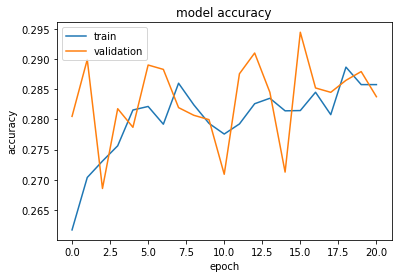

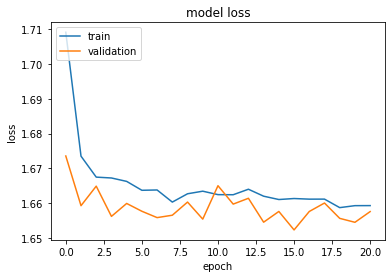

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


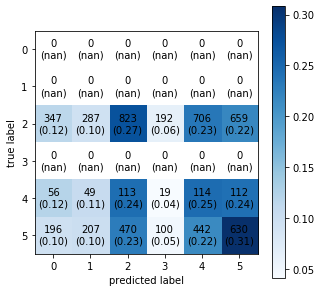

Training for fold 2 ...
Train on 22087 samples, validate on 5522 samples
Epoch 1/100
22087/22087 [==============================] - 1s 59us/step - loss: 1.7051 - accuracy: 0.2572 - val_loss: 1.6652 - val_accuracy: 0.2744
Epoch 2/100
22087/22087 [==============================] - 1s 35us/step - loss: 1.6706 - accuracy: 0.2745 - val_loss: 1.6581 - val_accuracy: 0.2869
Epoch 3/100
22087/22087 [==============================] - 1s 36us/step - loss: 1.6682 - accuracy: 0.2742 - val_loss: 1.6678 - val_accuracy: 0.2992
Epoch 4/100
22087/22087 [==============================] - 1s 36us/step - loss: 1.6637 - accuracy: 0.2778 - val_loss: 1.6696 - val_accuracy: 0.2738
Epoch 5/100
22087/22087 [==============================] - 1s 37us/step - loss: 1.6642 - accuracy: 0.2791 - val_loss: 1.6585 - val_accuracy: 0.2870
Epoch 6/100
22087/22087 [==============================] - 1s 35us/step - loss: 1.6646 - accuracy: 0.2747 - val_loss: 1.6603 - val_accuracy: 0.2883
Epoch 7/100
22087/22087 [==============

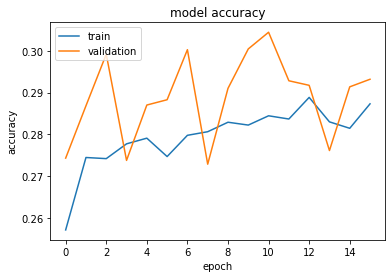

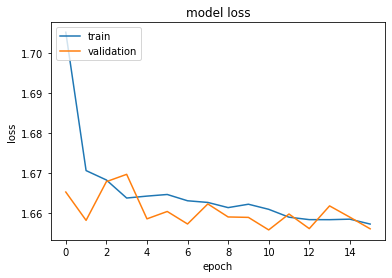

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


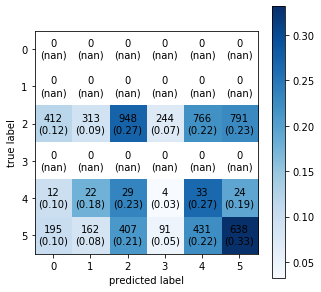

Training for fold 3 ...
Train on 22087 samples, validate on 5522 samples
Epoch 1/100
22087/22087 [==============================] - 1s 64us/step - loss: 1.7099 - accuracy: 0.2492 - val_loss: 1.6617 - val_accuracy: 0.2713
Epoch 2/100
22087/22087 [==============================] - 1s 40us/step - loss: 1.6746 - accuracy: 0.2691 - val_loss: 1.6593 - val_accuracy: 0.2789
Epoch 3/100
22087/22087 [==============================] - 1s 54us/step - loss: 1.6728 - accuracy: 0.2715 - val_loss: 1.6545 - val_accuracy: 0.2789
Epoch 4/100
22087/22087 [==============================] - 1s 36us/step - loss: 1.6692 - accuracy: 0.2757 - val_loss: 1.6484 - val_accuracy: 0.2903
Epoch 5/100
22087/22087 [==============================] - 1s 35us/step - loss: 1.6680 - accuracy: 0.2765 - val_loss: 1.6598 - val_accuracy: 0.2731
Epoch 6/100
22087/22087 [==============================] - 1s 35us/step - loss: 1.6691 - accuracy: 0.2736 - val_loss: 1.6500 - val_accuracy: 0.2852
Epoch 7/100
22087/22087 [==============

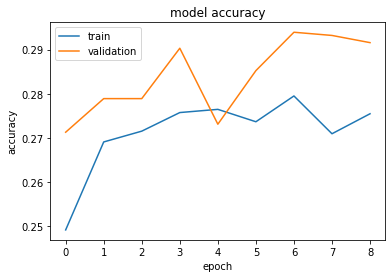

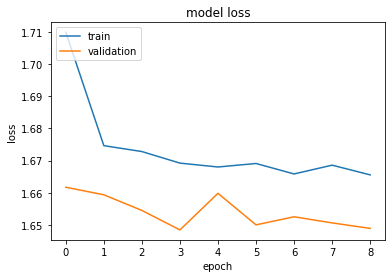

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


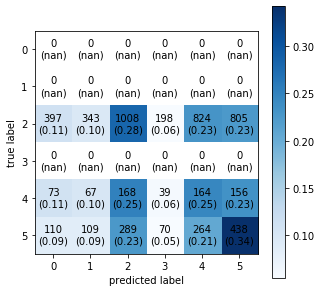

Training for fold 4 ...
Train on 22087 samples, validate on 5522 samples
Epoch 1/100
22087/22087 [==============================] - 1s 67us/step - loss: 1.7122 - accuracy: 0.2552 - val_loss: 1.6764 - val_accuracy: 0.2832
Epoch 2/100
22087/22087 [==============================] - 1s 44us/step - loss: 1.6752 - accuracy: 0.2701 - val_loss: 1.6664 - val_accuracy: 0.2524
Epoch 3/100
22087/22087 [==============================] - 1s 55us/step - loss: 1.6706 - accuracy: 0.2713 - val_loss: 1.6601 - val_accuracy: 0.2754
Epoch 4/100
22087/22087 [==============================] - 1s 36us/step - loss: 1.6687 - accuracy: 0.2765 - val_loss: 1.6677 - val_accuracy: 0.2707
Epoch 5/100
22087/22087 [==============================] - 1s 41us/step - loss: 1.6661 - accuracy: 0.2772 - val_loss: 1.6549 - val_accuracy: 0.2925
Epoch 6/100
22087/22087 [==============================] - 1s 38us/step - loss: 1.6624 - accuracy: 0.2809 - val_loss: 1.6582 - val_accuracy: 0.2850
Epoch 7/100
22087/22087 [==============

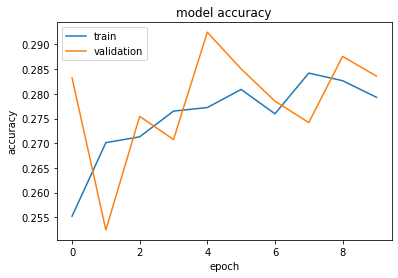

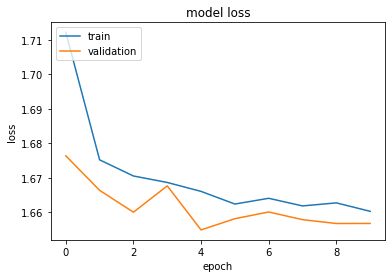

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


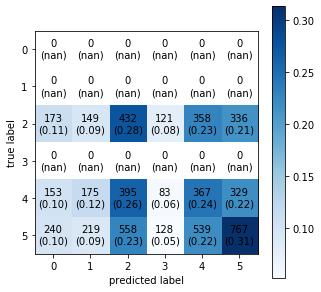

Training for fold 5 ...
Train on 22088 samples, validate on 5521 samples
Epoch 1/100
22088/22088 [==============================] - 1s 67us/step - loss: 1.7014 - accuracy: 0.2601 - val_loss: 1.6805 - val_accuracy: 0.2621
Epoch 2/100
22088/22088 [==============================] - 1s 41us/step - loss: 1.6725 - accuracy: 0.2723 - val_loss: 1.6733 - val_accuracy: 0.2820
Epoch 3/100
22088/22088 [==============================] - 1s 41us/step - loss: 1.6620 - accuracy: 0.2831 - val_loss: 1.6896 - val_accuracy: 0.2670
Epoch 4/100
22088/22088 [==============================] - 1s 40us/step - loss: 1.6609 - accuracy: 0.2863 - val_loss: 1.6781 - val_accuracy: 0.2677
Epoch 5/100
22088/22088 [==============================] - 1s 41us/step - loss: 1.6604 - accuracy: 0.2848 - val_loss: 1.6747 - val_accuracy: 0.2898
Epoch 6/100
22088/22088 [==============================] - 1s 40us/step - loss: 1.6590 - accuracy: 0.2886 - val_loss: 1.6739 - val_accuracy: 0.2835
Epoch 7/100
22088/22088 [==============

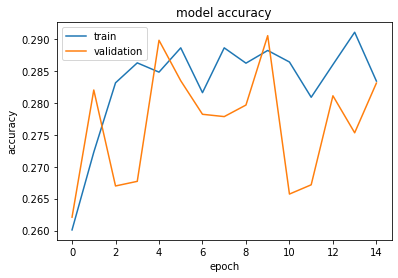

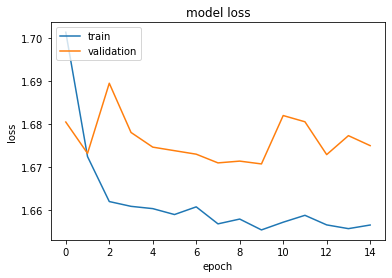

Confusion Matrix


/Users/harukageorge/opt/anaconda3/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:94: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


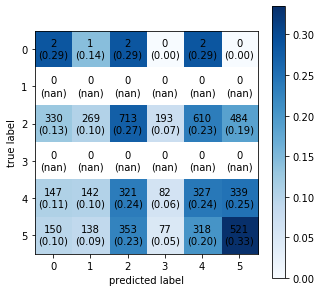

In [92]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)


# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold=[]
loss_per_fold=[]
for train, test in kfold.split(x_new, y_new):
    model = Sequential()
    model.add(Dense(128, input_dim=x_new[train].shape[1],
                    activation='tanh',
                    kernel_initializer='normal'))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='tanh'))
    
    model.add(Dense(6, activation='softmax'))
    #compiling model
    model.compile(optimizer= 'adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(f'Training for fold {fold_no} ...')
                    
    #fit the data to model
    hist = model.fit(x_new[train], y_new[train],
                     epochs=100,
                     batch_size=100,
                    validation_data=(x_new[test], y_new[test]),
                     verbose=1,
                    callbacks=[EarlyStop])
     # Generate generalization metrics
    scores = model.evaluate(x_new[test], y_new[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])    
 #   print(hist.history.keys())
 #  "Accuracy"
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # "Loss"
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    pred=model.predict(x_new[test])
    classes_x=np.argmax(pred,axis=1)
    #Accuracy score
    #print('Accuracy score'accuracy_score(classes_x, y[test]))
    
    #Confusion Matrix
    print('Confusion Matrix')
    cm = (confusion_matrix(classes_x, y_new[test]))
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(5,5),
    show_absolute = True,
    show_normed = True,
    colorbar = True)
    plt.show()
    #print(classification_report(p, test_y))
    
 # Increase fold number
    fold_no = fold_no + 1
    